In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorboard.backend.event_processing import event_accumulator

In [2]:
# Example code: Feel free to adapt
def steps_to_tokens(steps):
    dp_size = 14
    batch_size = 22
    seq_len = 2048
    divv = 1e9
    mult = (batch_size * seq_len * dp_size) / divv
    return [step * mult for step in steps]

def smooth(vals, factor):
    if factor == 0 or len(vals) == 0:
        return vals
    smoothed = []
    last = vals[0]
    for v in vals:
        last = last * factor + (1 - factor) * v
        smoothed.append(last)
    return smoothed

def get_all_event_paths(base_path):
    """Recursively collect all event files from base_path."""
    event_paths = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if "events" in file:
                event_paths.append(os.path.join(root, file))
    return event_paths

ppl_start_threshold = 250
smoothing_train = 0.99
smoothing_val = 0.

# Interaction mechanism

In [6]:

ckpt_paths = [

"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/aee1b094088d28df3a3351b42c1b3c2a/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/264241f84606ad4c10c13b10915f3ee6/tensorboard"
]

legend_keys = [
    "Additive Fusion",
    "GLU Fusion"

]

key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [7]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    # if "5845ec82011978ec8c42d1dc3d2ff8bd" in path:
    #     val_loss_sorted  = [val_loss_dict[s] + 0.04 for s in val_steps_sorted]
    # else:
    val_loss_sorted  = [val_loss_dict[s] + 0.25 for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]


    # if "60029fc14727bb8d5744292172fea0b5" in path:
    #     # print(len(train_loss))
    #     train_loss = [l  - 0.004 for l in train_loss]
    # # print(len(train_loss))

   



    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)
    print(train_steps[-1], path)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")


##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/aee1b094088d28df3a3351b42c1b3c2a/tensorboard
6.938624 /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/aee1b094088d28df3a3351b42c1b3c2a/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/264241f84606ad4c10c13b10915f3ee6/tensorboard
6.938624 /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/264241f84606ad4c10c13b10915f3ee6/tensorboard

All runs aggregated.
Global end step = 6.94 (tokens)


In [8]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Additive Fusion_GLU Fusion_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Additive Fusion_GLU Fusion_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Additive Fusion_GLU Fusion_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Additive Fusion_GLU Fusion_val_ppl.pdf


# Interaction mechnaism ends

# Rank Scaling

In [4]:

# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
# ]


ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/5845ec82011978ec8c42d1dc3d2ff8bd/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/1f65ba3582a38b9187acf686835ce870/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/8f4be006ea930abb7a0df7a0d18b6009/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/c2fcec3bc4a89d9be355b831d2cf5f52/tensorboard"
]


legend_keys = [
    "Rank 1 - 128 LOREs",
    "Rank 4 - 32 LOREs",
    "Rank 8 - 16 LOREs",
    "Rank 16 - 8 LOREs"
]






key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [5]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    if "5845ec82011978ec8c42d1dc3d2ff8bd" in path:
        val_loss_sorted  = [val_loss_dict[s] + 0.04 for s in val_steps_sorted]
    else:
        val_loss_sorted  = [val_loss_dict[s] for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]


    # if "60029fc14727bb8d5744292172fea0b5" in path:
    #     # print(len(train_loss))
    #     train_loss = [l  - 0.004 for l in train_loss]
    # # print(len(train_loss))

   



    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)
    print(train_steps[-1], path)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")


##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 2 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/5845ec82011978ec8c42d1dc3d2ff8bd/tensorboard
6.175174655999999 /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/5845ec82011978ec8c42d1dc3d2ff8bd/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/1f65ba3582a38b9187acf686835ce870/tensorboard
7.204614144 /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/1f65ba3582a38b9187acf686835ce870/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/8f4be006ea930abb7a0df7a0d18b6009/tensorboard
6.409138176 /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/8f4be006ea930abb7a0df7a0d18b6009/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12-lora/c2fcec3bc4a89d9be355b831d2cf5f52/tensorboard
6.123995136 /net/scratch/zsarwar/exps/GPT_experts-8-topk-

In [6]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Rank 1 - 128 LOREs_Rank 4 - 32 LOREs_Rank 8 - 16 LOREs_Rank 16 - 8 LOREs_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Rank 1 - 128 LOREs_Rank 4 - 32 LOREs_Rank 8 - 16 LOREs_Rank 16 - 8 LOREs_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Rank 1 - 128 LOREs_Rank 4 - 32 LOREs_Rank 8 - 16 LOREs_Rank 16 - 8 LOREs_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/Rank 1 - 128 LOREs_Rank 4 - 32 LOREs_Rank 8 - 16 LOREs_Rank 16 - 8 LOREs_val_ppl.pdf


# Rank Scaling Ends

# 2c1 LORA

In [3]:

# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
# ]
# legend_keys = [
#     "1c1-l-16-r8",
#     "1c1",
    
# ]


ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-base-moe/30bfe7ef0dd34c1baac36486d89a10eb/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-lora/5d6b03d799793fa8d078bf4198961ac9/tensorboard"
#"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-lora/137290d583bb9f4d1f290c1bd88ae9ae/tensorboard"
]
legend_keys = [
    "2c1",
    "2c1-l16-r8",
    #"4c1-l16-r8-k-2",
    
]





key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [4]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    val_loss_sorted  = [val_loss_dict[s] for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]


    # if "60029fc14727bb8d5744292172fea0b5" in path:
    #     # print(len(train_loss))
    #     train_loss = [l  - 0.004 for l in train_loss]
    # # print(len(train_loss))

   



    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)
    print(train_steps[-1], path)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")


##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-base-moe/30bfe7ef0dd34c1baac36486d89a10eb/tensorboard
7.859568640000001 /net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-base-moe/30bfe7ef0dd34c1baac36486d89a10eb/tensorboard

Found 2 event files in /net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-lora/5d6b03d799793fa8d078bf4198961ac9/tensorboard
7.49027328 /net/scratch/zsarwar/exps/GPT_experts-2-topk-1-layers12-heads-12-lora/5d6b03d799793fa8d078bf4198961ac9/tensorboard

All runs aggregated.
Global end step = 7.49 (tokens)


In [5]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/2c1_2c1-l16-r8_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/2c1_2c1-l16-r8_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/2c1_2c1-l16-r8_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/2c1_2c1-l16-r8_val_ppl.pdf


# 4c1 LORA ENDS


# 4c1 LORA

In [3]:

# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
# ]
# legend_keys = [
#     "1c1-l-16-r8",
#     "1c1",
    
# ]


ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/d34bb06e155633c60f279a6ff92f8d90/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-lora/60029fc14727bb8d5744292172fea0b5/tensorboard",
#"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-lora/137290d583bb9f4d1f290c1bd88ae9ae/tensorboard"
]
legend_keys = [
    "4c1",
    "4c1-l16-r8",
    #"4c1-l16-r8-k-2",
    
]





key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [10]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    val_loss_sorted  = [val_loss_dict[s] for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]


    # if "60029fc14727bb8d5744292172fea0b5" in path:
    #     # print(len(train_loss))
    #     train_loss = [l  - 0.004 for l in train_loss]
    # # print(len(train_loss))

   



    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)
    print(train_steps[-1], path)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")


##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 2 event files in /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/d34bb06e155633c60f279a6ff92f8d90/tensorboard
14.1582336 /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/d34bb06e155633c60f279a6ff92f8d90/tensorboard

Found 3 event files in /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-lora/60029fc14727bb8d5744292172fea0b5/tensorboard
8.73807872 /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-lora/60029fc14727bb8d5744292172fea0b5/tensorboard

All runs aggregated.
Global end step = 8.74 (tokens)


In [11]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-l16-r8_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-l16-r8_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-l16-r8_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-l16-r8_val_ppl.pdf


# 4c1 LORA ENDS


# 4c1 Hetro

In [68]:

# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
# ]
# legend_keys = [
#     "1c1-l-16-r8",
#     "1c1",
    
# ]


ckpt_paths = [
"/net/scratch/zsarwar/exps_t/GPT_experts-4-topk-1-layers12-heads-12/w001-446d5e9e78a690921a149c65320e1eea/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/14a61de6f166d8f3ccae64a958e06558/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-hetro/e3d7580a3c9ad108011ed2eb4321473f/tensorboard",
]
legend_keys = [
    "4c1",
    "4c1-FM",
    "4c1-Hetro",
    
]





key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [69]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    val_loss_sorted  = [val_loss_dict[s] for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]


    if "14a61de6f166d8f3ccae64a958e06558" in path:
        # print(len(train_loss))
        train_loss = [l  + 0.015 for l in train_loss]
    # print(len(train_loss))

    if "e3d7580a3c9ad108011ed2eb4321473f" in path:
        # print(len(train_loss))
        train_loss = [l  - 0.015 for l in train_loss]
   



    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")

##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 1 event files in /net/scratch/zsarwar/exps_t/GPT_experts-4-topk-1-layers12-heads-12/w001-446d5e9e78a690921a149c65320e1eea/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/14a61de6f166d8f3ccae64a958e06558/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-hetro/e3d7580a3c9ad108011ed2eb4321473f/tensorboard

All runs aggregated.
Global end step = 22.49 (tokens)


In [70]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-FM_4c1-Hetro_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-FM_4c1-Hetro_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-FM_4c1-Hetro_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/4c1_4c1-FM_4c1-Hetro_val_ppl.pdf


# 4c1 HETRO ENDS


# 1c1 LORA

In [51]:

# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
# ]
# legend_keys = [
#     "1c1-l-16-r8",
#     "1c1",
    
# ]


ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
]
legend_keys = [
    "LoRE-Dense",
    "Dense Baseline",
    

]




key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/{key_x}.pdf"  # Set to None to disable saving


In [52]:

train_steps_all, train_loss_all, train_ppl_all = [], [], []
val_steps_all,   val_loss_all,   val_ppl_all   = [], [], []

for path in ckpt_paths:
    event_paths = get_all_event_paths(path)
    print(f"\nFound {len(event_paths)} event files in {path}")

    # dict for step→value (last-write-wins on duplicates)
    train_loss_dict = {}
    val_loss_dict   = {}
    val_ppl_dict    = {}

    for event_path in event_paths:
        try:
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            train_loss_events = ea.Scalars("train/lm_loss")
            val_loss_events   = ea.Scalars("validation/lm_loss")
            val_ppl_events    = ea.Scalars("validation/lm_loss_ppl")

            # Overwrite repeated step entries with latest
            for e in train_loss_events:
                train_loss_dict[e.step] = e.value
            for e in val_loss_events:
                val_loss_dict[e.step] = e.value
            for e in val_ppl_events:
                val_ppl_dict[e.step] = e.value

        except Exception as ex:
            print(f"Error loading {event_path}: {ex}")
            continue

    if not train_loss_dict:
        print(f"No valid training data found in {path}. Skipping.")
        continue

    # Sort training steps
    train_steps_sorted = sorted(train_loss_dict.keys())
    train_loss_sorted  = [train_loss_dict[s] for s in train_steps_sorted]
    train_ppl_sorted   = [np.exp(v) for v in train_loss_sorted]

    # Sort validation steps
    val_steps_sorted = sorted(val_loss_dict.keys())
    val_loss_sorted  = [val_loss_dict[s] for s in val_steps_sorted]
    val_ppl_sorted   = [val_ppl_dict[s] for s in val_steps_sorted] if val_ppl_dict else []

    # Clip out early training steps with high PPL
    start_idx = next((i for i, v in enumerate(train_ppl_sorted) if v < ppl_start_threshold), 0)
    train_steps = train_steps_sorted[start_idx:]
    train_loss  = train_loss_sorted[start_idx:]
    train_ppl   = train_ppl_sorted[start_idx:]

    # Smooth train
    train_loss = smooth(train_loss, smoothing_train)
    train_ppl  = smooth(train_ppl,  smoothing_train)

    # Convert training steps to tokens
    train_steps = steps_to_tokens(train_steps)

    # For validation, skip early region if val_ppl exists
    if val_ppl_sorted:
        start_val_idx = next((i for i, v in enumerate(val_ppl_sorted) if v < ppl_start_threshold), 0)
    else:
        start_val_idx = 0
    val_steps = val_steps_sorted[start_val_idx:]
    val_loss  = val_loss_sorted[start_val_idx:]
    val_ppl   = val_ppl_sorted[start_val_idx:] if val_ppl_sorted else []
    val_loss  = smooth(val_loss, smoothing_val)
    val_ppl   = smooth(val_ppl,  smoothing_val)
    val_steps = steps_to_tokens(val_steps)

    # Store in final arrays
    train_steps_all.append(train_steps)
    train_loss_all.append(train_loss)
    train_ppl_all.append(train_ppl)

    val_steps_all.append(val_steps)
    val_loss_all.append(val_loss)
    val_ppl_all.append(val_ppl)

print("\nAll runs aggregated.")

##############################################################################
# 2) FIND THE MINIMUM FINAL STEP ACROSS ALL RUNS & CLIP
##############################################################################

# We'll look at the last training step for each run,
# take the minimum of those "final steps", call it `global_end_step`,
# and clip each run so we only keep data points up to that step.

# 2A) For each run, find final step
final_train_steps = []
for steps in train_steps_all:
    if len(steps) == 0:
        final_train_steps.append(0.0)
    else:
        final_train_steps.append(steps[-1])  # last step in tokens

# 2B) global_end_step = minimum of these final steps
global_end_step = min(final_train_steps)
print(f"Global end step = {global_end_step:.2f} (tokens)")

# 2C) Clip all runs to that end step
def clip_run_to_step(x_vals, y_vals, end_step):
    """
    Keep only the points where x_vals[i] <= end_step.
    x_vals and y_vals are same length, sorted in ascending order of x_vals.
    """
    clipped_x, clipped_y = [], []
    for (xx, yy) in zip(x_vals, y_vals):
        if xx <= end_step:
            clipped_x.append(xx)
            clipped_y.append(yy)
        else:
            break
    return clipped_x, clipped_y

num_runs = len(train_steps_all)
for i in range(num_runs):
    # Train
    old_x = train_steps_all[i]
    old_loss = train_loss_all[i]
    new_x, new_loss = clip_run_to_step(old_x, old_loss, global_end_step)
    train_steps_all[i] = new_x
    train_loss_all[i]  = new_loss

    old_ppl = train_ppl_all[i]
    _, new_ppl = clip_run_to_step(old_x, old_ppl, global_end_step)
    train_ppl_all[i] = new_ppl

    # Validation
    old_valx = val_steps_all[i]
    old_vloss= val_loss_all[i]
    new_valx, new_vloss = clip_run_to_step(old_valx, old_vloss, global_end_step)
    val_steps_all[i] = new_valx
    val_loss_all[i]  = new_vloss

    old_vppl = val_ppl_all[i]
    _, new_vppl = clip_run_to_step(old_valx, old_vppl, global_end_step)
    val_ppl_all[i] = new_vppl




Found 3 event files in /net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard

Found 1 event files in /net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard

All runs aggregated.
Global end step = 7.43 (tokens)


In [53]:
# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(7, 5))

# Train Loss
for i in range(len(ckpt_paths)):    
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")


ax1.grid(True)
ax1.legend()

# Save Train Loss plot
train_loss_save_path = save_path.replace(".pdf", "_train_loss.pdf")
plt.savefig(train_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax2 = plt.subplots(figsize=(7, 5))

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Save Validation Loss plot
val_loss_save_path = save_path.replace(".pdf", "_val_loss.pdf")
plt.savefig(val_loss_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_loss_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax3 = plt.subplots(figsize=(7, 5))

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Save Train PPL plot
train_ppl_save_path = save_path.replace(".pdf", "_train_ppl.pdf")
plt.savefig(train_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {train_ppl_save_path}")
plt.close(fig)

# --- Plotting ---
fig, ax4 = plt.subplots(figsize=(7, 5))

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

# Save Validation PPL plot
val_ppl_save_path = save_path.replace(".pdf", "_val_ppl.pdf")
plt.savefig(val_ppl_save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {val_ppl_save_path}")
plt.close(fig)

Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/LoRE-Dense_Dense Baseline_train_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/LoRE-Dense_Dense Baseline_val_loss.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/LoRE-Dense_Dense Baseline_train_ppl.pdf
Saved plot to: /home/zsarwar/Projects/gpt_neox/gpt-neox/code/plots/LoRE-Dense_Dense Baseline_val_ppl.pdf


# 1c1 LORA ENDS


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator



# ckpt_paths = [
#     "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/b001-9aae413635a59a1bd748912a1d6a8077/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/j002-f8d4350954da3c455cfb58e12936d732/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/w002-300bc04cda9f137ea77a2da53d51d3f4/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12/k001-e219b0857385c22aca203fa5ca4c6110_2/tensorboard"
# ]
# legend_keys = [
#     "1c1 + l-16-r-8",
#     # "1c1 + l-8_r-4",
#     "1c1",
#     # "1c1 + l-16-r-4",

# ]


# # === Config ===
# ckpt_paths = [
#     "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers12-heads-12/k001-38abff837ec0d231d3e9eb56c9cdb6ac/tensorboard/",
#     # "/net/scratch/zsarwar/exps/GPT_experts-8-topk-2-layers12-heads-12/k001-bf438c8582fa76d72c2527fa61802b74/tensorboard",
#     "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/e002-af3b953a6664974775edb480246a64fc/tensorboard",
#     # "/net/scratch/zsarwar/exps/GPT_experts-7-topk-1-layers12-heads-12/b003-82d0e08a0c26696f7991aaa0671ae599/tensorboard"
# ]
# legend_keys = [
#     "8c1",
#     # "8c2",
#     "7c1+Lora8c1",
#     # "7c1",

# ]


# # === Config ===
# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12/w001-446d5e9e78a690921a149c65320e1eea/tensorboard/",
# "/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12/w001-ec38fe523db7eb59419fcd573e308e8d/tensorboard/"
# ]
# legend_keys = [
#     "4c1",
#     "4c1 + l-16-r-8"
# ]



# # === Config ===
# ckpt_paths = [
# "/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-hetro/e3d7580a3c9ad108011ed2eb4321473f/tensorboard",
# "/net/scratch/zsarwar/exps/GPT_experts-4-topk-1-layers12-heads-12-base-moe/14a61de6f166d8f3ccae64a958e06558/tensorboard",
# "/net/scratch/zsarwar/exps_t/GPT_experts-4-topk-1-layers12-heads-12/w001-446d5e9e78a690921a149c65320e1eea/tensorboard"
# ]
# legend_keys = [
#     "4c1-hetro",
#     "4c1 + param-matched",
#     "4c1"

# ]

ckpt_paths = [
"/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-lora/ad16eaf0ab491faf8f7dff350be0c984/tensorboard",
"/net/scratch/zsarwar/exps/GPT_experts-1-topk-1-layers12-heads-12-base-moe/0e276af611df1ee7b123423ddae1e8e3/tensorboard"
]
legend_keys = [
    "1c1-l-16-r8",
    "1c1",
    

]



key_x = '_'.join(legend_keys)
save_path = f"/home/zsarwar/Projects/neox/gpt-neox-base-moe/code/plots/{key_x}.pdf"  # Set to None to disable saving


def steps_to_tokens(steps):
    dp_size = 16
    batch_size = 36
    seq_len = 2048
    divv = 1e9
    mult = (batch_size * seq_len * dp_size) / divv
    tokens = [step * mult for step in steps]
    return tokens

ppl_start_threshold = 70
smoothing_train = 0.9
smoothing_val = 0.4

def smooth(vals, factor):
    if factor == 0:
        return vals
    smoothed = []
    last = vals[0]
    for v in vals:
        last = last * factor + (1 - factor) * v
        smoothed.append(last)
    return smoothed

# --- Storage ---
train_loss_all = []
val_loss_all = []
train_ppl_all = []
val_ppl_all = []
train_steps_all = []
val_steps_all = []

# --- Load runs ---
for path in ckpt_paths:
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    train_loss_events = ea.Scalars("train/lm_loss")
    val_loss_events = ea.Scalars("validation/lm_loss")
    val_ppl_events = ea.Scalars("validation/lm_loss_ppl")

    steps = [e.step for e in train_loss_events]
    # if "e3d7580a3c9ad108011ed2eb4321473f" in path:
        # train_loss = [(e.value - 0.05) for e in train_loss_events]
    # else:
    train_loss = [e.value for e in train_loss_events]
    train_ppl = [np.exp(v) for v in train_loss]

    start = next((i for i, v in enumerate(train_ppl) if v < ppl_start_threshold), 0)

    steps = steps_to_tokens(steps[start:])

    train_loss = smooth(train_loss[start:], smoothing_train)
    train_ppl = smooth(train_ppl[start:], smoothing_train)

    val_steps = steps_to_tokens([e.step for e in val_loss_events])
    val_loss = smooth([e.value for e in val_loss_events], smoothing_val)
    val_ppl = smooth([e.value for e in val_ppl_events], smoothing_val)



    train_steps_all.append(steps)
    val_steps_all.append(val_steps)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_ppl_all.append(train_ppl)
    val_ppl_all.append(val_ppl)



# --- Clip to shortest run for training plots ---
min_train_len = min(len(steps) for steps in train_steps_all)

for i in range(len(train_steps_all)):
    train_steps_all[i] = train_steps_all[i][:min_train_len]
    train_loss_all[i] = train_loss_all[i][:min_train_len]
    train_ppl_all[i] = train_ppl_all[i][:min_train_len]


# --- Clip to shortest run for valing plots ---
min_val_len = min(len(steps) for steps in val_steps_all)

for i in range(len(val_steps_all)):
    val_steps_all[i] = val_steps_all[i][:min_val_len]
    val_loss_all[i] = val_loss_all[i][:min_val_len]
    val_ppl_all[i] = val_ppl_all[i][:min_val_len]







# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

# Train Loss
for i in range(len(ckpt_paths)):
    ax1.plot(train_steps_all[i], train_loss_all[i], label=legend_keys[i])
ax1.set_title("Train Loss")
ax1.set_xlabel("Tokens (B)")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Validation Loss
for i in range(len(ckpt_paths)):
    ax2.plot(val_steps_all[i], val_loss_all[i], label=legend_keys[i])
ax2.set_title("Validation Loss")
ax2.set_xlabel("Tokens (B)")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train PPL
for i in range(len(ckpt_paths)):
    ax3.plot(train_steps_all[i], train_ppl_all[i], label=legend_keys[i])
ax3.set_title("Train Perplexity")
ax3.set_xlabel("Tokens (B)")
ax3.set_ylabel("PPL")
ax3.grid(True)
ax3.legend()

# Validation PPL
for i in range(len(ckpt_paths)):
    ax4.plot(val_steps_all[i], val_ppl_all[i], label=legend_keys[i])
ax4.set_title("Validation Perplexity")
ax4.set_xlabel("Tokens (B)")
ax4.set_ylabel("PPL")
ax4.grid(True)
ax4.legend()

plt.tight_layout()



# --- Save as PDF if specified ---
if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")


plt.show()

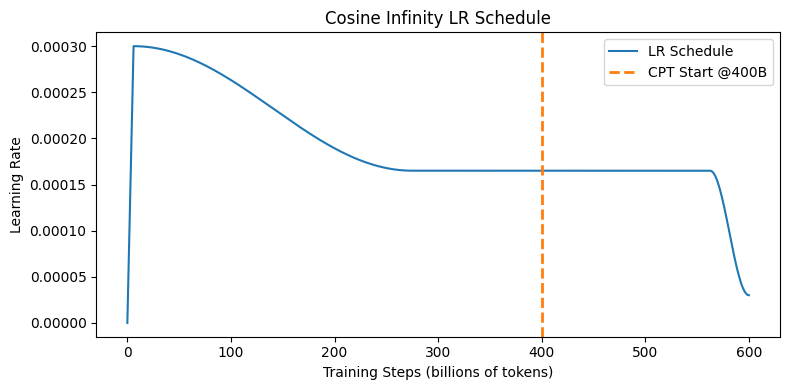

In [55]:
import matplotlib.pyplot as plt
import math

def make_cpt_schedule(
    total_steps=600,       # total “billions of tokens”
    pct_warmup=0.01,       # fraction for linear warmup
    decay_end=275,         # step (in B) where cosine decay down to lr_const ends
    const_end=562.5,       # step where constant lr_const ends and CPT decay begins
    lr_max=3e-4,           # peak LR after warmup
    lr_const=1.65e-4,      # LR plateau before & during CPT
    lr_min=3e-5,           # final LR at end of CPT
):
    warmup_end = pct_warmup * total_steps
    decay_len  = decay_end - warmup_end
    const_len  = const_end - decay_end
    final_len  = total_steps - const_end

    def lr_at(step):
        if step <= warmup_end:
            return lr_max * (step / warmup_end)
        if step <= decay_end:
            t = (step - warmup_end) / decay_len
            return lr_const + 0.5 * (lr_max - lr_const) * (1 + math.cos(math.pi * t))
        if step <= const_end:
            return lr_const
        t = (step - const_end) / final_len
        return lr_min + 0.5 * (lr_const - lr_min) * (1 + math.cos(math.pi * t))

    return [lr_at(s) for s in range(int(total_steps) + 1)]

# generate and plot
total_steps = 600
sched = make_cpt_schedule(
    total_steps=total_steps,
    pct_warmup=0.01,
    decay_end=275,
    const_end=562.5,
    lr_max=3e-4,
    lr_const=1.65e-4,
    lr_min=3e-5,
)

steps = list(range(int(total_steps) + 1))
plt.figure(figsize=(8,4))
plt.plot(steps, sched, label='LR Schedule')
plt.axvline(
    x=400,
    color='C1',         # different color
    linestyle='--',
    linewidth=2,
    label='CPT Start @400B'
)
plt.xlabel('Training Steps (billions of tokens)')
plt.ylabel('Learning Rate')
plt.title('Cosine Infinity LR Schedule')
plt.legend()
plt.tight_layout()
plt.show()

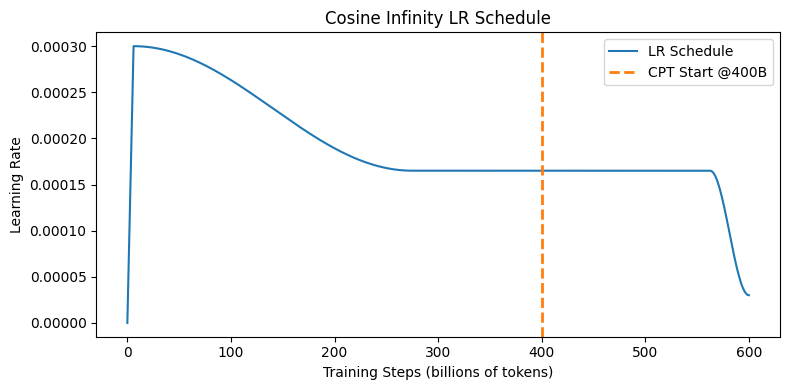

In [63]:
import matplotlib.pyplot as plt
import math

def make_cpt_schedule(
    total_steps=600,       # total “billions of tokens”
    pct_warmup=0.01,       # fraction for linear warmup
    decay_end=275,         # step (in B) where cosine decay down to lr_const ends
    const_end=562.5,       # step where constant lr_const ends and CPT decay begins
    lr_max=3e-4,           # peak LR after warmup
    lr_const=1.65e-4,      # LR plateau before & during CPT
    lr_min=3e-5,           # final LR at end of CPT
):
    warmup_end = pct_warmup * total_steps
    decay_len  = decay_end - warmup_end
    const_len  = const_end - decay_end
    final_len  = total_steps - const_end

    def lr_at(step):
        if step <= warmup_end:
            return lr_max * (step / warmup_end)
        if step <= decay_end:
            t = (step - warmup_end) / decay_len
            return lr_const + 0.5 * (lr_max - lr_const) * (1 + math.cos(math.pi * t))
        if step <= const_end:
            return lr_const
        t = (step - const_end) / final_len
        return lr_min + 0.5 * (lr_const - lr_min) * (1 + math.cos(math.pi * t))

    return [lr_at(s) for s in range(int(total_steps) + 1)]

# generate and plot
total_steps = 600
sched = make_cpt_schedule(
    total_steps=total_steps,
    pct_warmup=0.01,
    decay_end=275,
    const_end=562.5,
    lr_max=3e-4,
    lr_const=1.65e-4,
    lr_min=3e-5,
)

steps = list(range(int(total_steps) + 1))
plt.figure(figsize=(8,4))
plt.plot(steps, sched, label='LR Schedule')
plt.axvline(
    x=400,
    color='C1',         # different color
    linestyle='--',
    linewidth=2,
    label='CPT Start @400B'
)
plt.xlabel('Training Steps (billions of tokens)')
plt.ylabel('Learning Rate')
plt.title('Cosine Infinity LR Schedule')
plt.legend()
plt.tight_layout()
plt.savefig("cosine_inf.pdf", bbox_inches='tight')
plt.show()

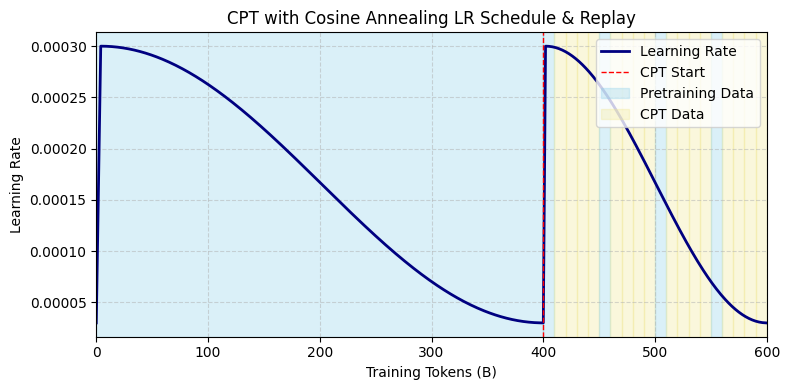

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def plot_rewarm_cosine_schedule_with_replay(
    pre_steps=400,          # Pretraining duration (B tokens)
    cpt_steps=200,          # CPT duration (B tokens)
    pct_warmup=0.01,        # fraction for linear warmup in each phase
    lr_min=3e-5,
    lr_max=3e-4,
    num_tiles=20,           # how many vertical slices in CPT
    replay_frac=0.2         # fraction of slices that are replay
):
    total_steps = pre_steps + cpt_steps
    steps = np.arange(total_steps)
    
    # 1) Pretraining LR: warmup → cosine decay
    pre_warm  = int(pre_steps * pct_warmup)
    pre_decay = pre_steps - pre_warm
    lr_pre = np.empty(pre_steps)
    lr_pre[:pre_warm] = np.linspace(lr_min, lr_max, pre_warm, endpoint=False)
    d = np.arange(pre_decay)
    lr_pre[pre_warm:] = lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * d / pre_decay))
    
    # 2) CPT LR: re-warmup → cosine decay
    cpt_warm  = int(cpt_steps * pct_warmup)
    cpt_decay = cpt_steps - cpt_warm
    lr_cpt = np.empty(cpt_steps)
    lr_cpt[:cpt_warm] = np.linspace(lr_min, lr_max, cpt_warm, endpoint=False)
    d2 = np.arange(cpt_decay)
    lr_cpt[cpt_warm:] = lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * d2 / cpt_decay))
    
    lr = np.concatenate([lr_pre, lr_cpt])
    
    # 3) Mark replay vs new data in CPT
    replay_tiles = int(np.round(num_tiles * replay_frac))
    interval = num_tiles / replay_tiles if replay_tiles else np.inf
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(steps, lr, color='navy', lw=2, label='Learning Rate')
    
    # Pretraining region
    ax.axvspan(0, pre_steps, color='skyblue', alpha=0.3)
    
    # CPT region: tile entire [pre_steps, total_steps]
    tile_size = cpt_steps / num_tiles
    for t in range(num_tiles):
        start = pre_steps + t * tile_size
        end   = start + tile_size
        if replay_tiles and (t % int(np.ceil(interval)) == 0):
            shade = 'skyblue'
        else:
            shade = 'khaki'
        ax.axvspan(start, end, color=shade, alpha=0.3)
    
    # CPT start marker
    cpt_line = ax.axvline(pre_steps, color='red', linestyle='--', lw=1, label='CPT Start')
    
    # Legend
    handles = [
        Line2D([], [], color='navy', lw=2),
        cpt_line,
        mpatches.Patch(color='skyblue', alpha=0.3),
        mpatches.Patch(color='khaki', alpha=0.3),
    ]
    labels  = ['Learning Rate','CPT Start','Pretraining Data','CPT Data']
    ax.legend(handles, labels, loc='upper right')
    
    ax.set_xlim(0, total_steps)
    ax.set_xlabel('Training Tokens (B)')
    ax.set_ylabel('Learning Rate')
    ax.set_title('CPT with Cosine Annealing LR Schedule & Replay')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("cosine_annealing.pdf", bbox_inches='tight')
    plt.show()

# Example usage:
plot_rewarm_cosine_schedule_with_replay()

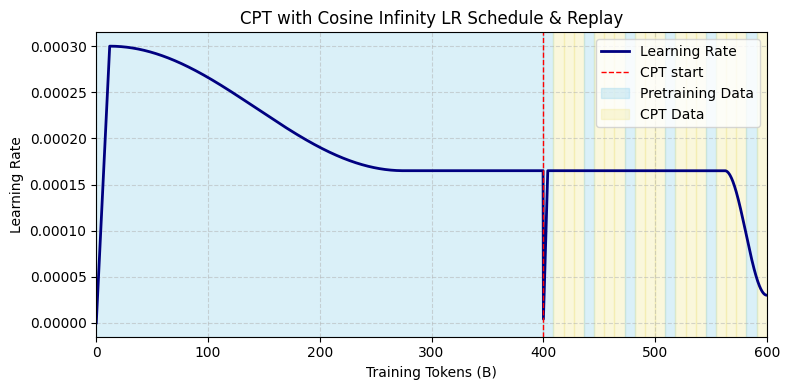

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def plot_cpt_replay_schedule(
    total_steps=600,
    pct_warmup=0.02,
    lr_max=3e-4,
    lr_const=1.65e-4,
    lr_min=3e-5,
    pre_cos_end=275,
    cpt_start=400,
    cpt_plateau_end=562.5,
    num_tiles=20,
    replay_frac=0.2
):
    # build 1D array of steps
    steps = np.linspace(0, total_steps, 2000)
    lr = np.zeros_like(steps)
    warmup_end = pct_warmup * total_steps

    # compute warmup length at CPT (in same units)
    cpt_steps = total_steps - cpt_start
    cpt_warm = pct_warmup * cpt_steps

    for i, s in enumerate(steps):
        if s < warmup_end:
            # pretrain warmup 0→lr_max
            lr[i] = lr_max * (s / warmup_end)
        elif s < pre_cos_end:
            # pretrain cosine down to lr_const
            frac = (s - warmup_end) / (pre_cos_end - warmup_end)
            lr[i] = lr_const + 0.5*(lr_max - lr_const)*(1 + np.cos(np.pi*frac))
        elif s < cpt_start:
            # pre-CPT constant
            lr[i] = lr_const
        elif s < cpt_start + cpt_warm:
            # CPT warmup 0→lr_const
            lr[i] = lr_const * ((s - cpt_start) / cpt_warm)
        elif s < cpt_plateau_end:
            # CPT plateau at lr_const
            lr[i] = lr_const
        else:
            # final cosine decay to lr_min
            frac = (s - cpt_plateau_end) / (total_steps - cpt_plateau_end)
            lr[i] = lr_min + 0.5*(lr_const - lr_min)*(1 + np.cos(np.pi*frac))

    # set up replay tiling over entire CPT region
    replay_tiles = int(np.round(num_tiles * replay_frac))
    interval = num_tiles / replay_tiles if replay_tiles > 0 else np.inf

    fig, ax = plt.subplots(figsize=(8, 4))
    line_lr, = ax.plot(steps, lr, color='navy', lw=2, label='Learning Rate')

    # pretraining shading
    ax.axvspan(0, cpt_start, color='skyblue', alpha=0.3)

    # interleaved shading from CPT start to end
    span = total_steps - cpt_start
    tile = span / num_tiles
    for t in range(num_tiles):
        start = cpt_start + t * tile
        color = 'skyblue' if (replay_tiles and t % int(np.ceil(interval)) == 0) else 'khaki'
        ax.axvspan(start, start + tile, color=color, alpha=0.3)

    # CPT start marker
    cpt_line = ax.axvline(cpt_start, color='red', linestyle='--', lw=1, label='CPT start')

    # legend
    handles = [
        line_lr,
        cpt_line,
        mpatches.Patch(color='skyblue', alpha=0.3, label='Pretraining Data'),
        mpatches.Patch(color='khaki',  alpha=0.3, label='CPT Data'),
    ]
    ax.legend(handles=handles, loc='upper right')

    ax.set_xlim(0, total_steps)
    ax.set_xlabel('Training Tokens (B)')
    ax.set_ylabel('Learning Rate')
    ax.set_title('CPT with Cosine Infinity LR Schedule & Replay')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("cosine_inf.pdf", bbox_inches='tight')
    plt.show()

# example
plot_cpt_replay_schedule(num_tiles=22, replay_frac=0.3)